In [1]:
import vtracer
from PIL import Image

import io

import cairosvg
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter


In [2]:
input = "/home/anhndt/draw_with_llms/data/results/version_4_sdxl_turbo_15--unknown_processing/ad4c5c-a starlit night over snow-covered peaks/raw - 0 - 0.6954.png"
output = "/home/anhndt/draw_with_llms/notebooks/a_snowy_plain_sdxl_turbo.vtracer.png"

In [6]:
from PIL import Image
import numpy as np
import cv2

def limit_colors_kmeans(image: Image.Image, n_colors: int = 6) -> Image.Image:
    """
    Giới hạn số màu trong ảnh bằng KMeans sử dụng OpenCV.
    
    Args:
        image (Image.Image): Ảnh đầu vào (PIL).
        n_colors (int): Số màu tối đa mong muốn trong ảnh.
    
    Returns:
        Image.Image: Ảnh đầu ra đã được giảm màu (PIL).
    """
    # Chuyển ảnh PIL → NumPy (RGB → BGR để phù hợp với OpenCV)
    img_np = np.array(image.convert("RGB"))[:, :, ::-1]

    # Đưa về dạng (num_pixels, 3)
    pixels = img_np.reshape(-1, 3).astype(np.float32)

    # KMeans clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    _, labels, centers = cv2.kmeans(
        data=pixels,
        K=n_colors,
        bestLabels=None,
        criteria=criteria,
        attempts=10,
        flags=cv2.KMEANS_PP_CENTERS
    )

    # Gán màu theo cluster
    quantized = centers[labels.flatten()].reshape(img_np.shape).astype(np.uint8)

    # Chuyển lại từ BGR → RGB → PIL Image
    quantized_rgb = quantized[:, :, ::-1]
    return Image.fromarray(quantized_rgb)


In [10]:
image = Image.open(input)
limit_color = limit_colors_kmeans(image)
limit_color = limit_color.convert("RGBA")
resized_img = limit_color.resize((384, 384), Image.Resampling.LANCZOS)  # hoặc Image.LANCZOS (mới hơn)
pixels: list[tuple[int, int, int, int]] = list(resized_img.getdata())


In [11]:
svg_str: str = vtracer.convert_pixels_to_svg(
    rgba_pixels=pixels,
    size=resized_img.size,
    colormode="color",        # ["color"] or "binary"
    hierarchical="stacked",     # ["stacked"] or "cutout"
    mode="polygon",             # ["spline"], "polygon", "none"
    filter_speckle=20,   # default: 4
    color_precision=6,  # default: 6
    layer_difference=16, # default: 16
    corner_threshold=60, # default: 60   
    length_threshold=4.0, # in [3.5, 10] default: 4.0
    max_iterations=10,   # default: 10
    splice_threshold=45, # default: 45
    path_precision=8,   # default: 8
)
len(svg_str.encode('utf-8'))

29586

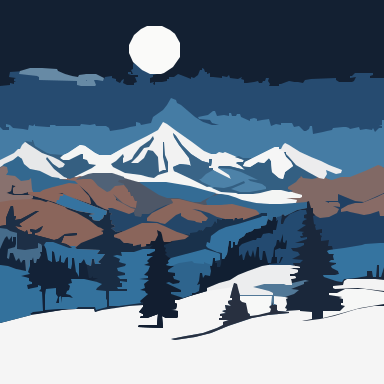

In [12]:
from IPython.display import SVG, display

display(SVG(svg_str))


In [13]:
with open("output.svg", "w", encoding="utf-8") as f:
    f.write(svg_str)

In [48]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from io import BytesIO
from PIL import Image
import vtracer
import re
from itertools import product


default_svg = """
        <svg xmlns="http://www.w3.org/2000/svg" width="384" height="384"><rect width="100%" height="100%"/>
        <path d="M218 333v-3m-5-6c6-2 5 4 5 4m0 0s-6-2-6 2c1 5 6 0 6 0m0-2v2M221 324l4 9m0 0 3-9m-3 9-4 4M128.5 341.5l2.5 8.5 3-7.5 3.5 7.5 2.5-8.5M196 338v14M153.5 351v-7m0-7v7m0 0s7-7.5 6.5 7"/>
        <path id="h" d="M180.5 342v6.5m0 2.5v-2.5m0 0s-7.5 7.5-6.5-7"/><use x="64" y="18" href="#h" transform="rotate(180 241 364)"/>
        <path d="M143 342v9m0-11v-2M131 369v-11l8 11v-12M173 369l3-5m4-4-4 4m0 0-3-4m3 4 3 5M239.5 331l-1 4M246.5 349l-1 4"/>
        </svg>"""


def parse_svg_path_d(d_str):
    import re

    commands = re.findall(r"[MLZmlz]|-?\d*\.?\d+", d_str)
    points = []
    i = 0
    while i < len(commands):
        cmd = commands[i]
        if cmd.upper() in ["M", "L"]:
            x = float(commands[i + 1])
            y = float(commands[i + 2])
            points.append([x, y])
            i += 3
        else:
            i += 1
    return np.array(points, dtype=np.float32)


def simplify_polygon(points, epsilon):
    return cv2.approxPolyDP(points, epsilon, closed=False).reshape(-1, 2)


def points_to_svg_path(points):
    if len(points) == 0:
        return ""
    d = f"M{points[0][0]},{points[0][1]} "
    for pt in points[1:]:
        d += f"L{pt[0]},{pt[1]} "
    return d.strip()


def simplify_svg_file(svg_str, epsilon=1.0) -> str:
    def simplify_path_d(match):
        original_d = match.group(1)
        try:
            points = parse_svg_path_d(original_d)
            if len(points) < 2:
                return f'd="{original_d}"'
            simplified = simplify_polygon(points, epsilon)
            new_d = points_to_svg_path(simplified)
            return f'd="{new_d}"'
        except Exception as e:
            print(f"⚠️ Lỗi xử lý path: {e}")
            return f'd="{original_d}"'

    # Tìm và xử lý các thuộc tính d="...":
    simplified_svg = re.sub(r'd="([^"]+)"', simplify_path_d, svg_str)

    # Đảm bảo có </svg> ở cuối
    if not simplified_svg.strip().endswith("</svg>"):
        simplified_svg += "\n</svg>"

    print(
        f"📦 Dung lượng sau khi đơn giản hóa: {len(simplified_svg.encode('utf-8'))} bytes"
    )
    return simplified_svg


def remove_version_attribute(svg_str: str) -> str:
    ET.register_namespace("", "http://www.w3.org/2000/svg")
    tree = ET.ElementTree(ET.fromstring(svg_str))
    root = tree.getroot()

    if "version" in root.attrib:
        del root.attrib["version"]

    output = BytesIO()
    tree.write(output, encoding="utf-8", xml_declaration=True)
    return output.getvalue().decode("utf-8")


def find_best_epsilon(svg_str, target_min=9700, target_max=9800, max_iter=20):
    low = 0.1
    high = 10.0
    best_epsilon = None
    best_svg = default_svg
    best_size = float("inf")

    for _ in range(max_iter):
        mid = (low + high) / 2
        simplified_svg = simplify_svg_file(svg_str, epsilon=mid)
        simplified_svg = remove_version_attribute(simplified_svg)
        size = len(simplified_svg.encode("utf-8"))

        if target_min <= size <= target_max:
            best_epsilon = mid
            best_svg = simplified_svg
            best_size = size
            low = mid  # thử tăng epsilon tiếp để đơn giản hóa hơn
        elif size > target_max:
            low = mid  # quá lớn → tăng epsilon
        else:
            high = mid  # quá nhỏ → giảm epsilon

    return best_epsilon, best_size, best_svg


def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    Adds nested circles with second darkest and second brightest colors from the existing SVG,
    positioned in one of the four corners (randomly selected) but positioned to avoid being
    cropped out during image processing.

    Parameters:
    -----------
    svg_code : str
        The original SVG string

    Returns:
    --------
    str
        Modified SVG with the nested circles added
    """
    import random
    import re
    from colorsys import rgb_to_hls, hls_to_rgb

    # Check if SVG has a closing tag
    if "</svg>" not in svg_code:
        return svg_code

    # Extract viewBox if it exists to understand the dimensions
    viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
    if viewbox_match:
        viewbox = viewbox_match.group(1).split()
        try:
            x, y, width, height = map(float, viewbox)
        except ValueError:
            # Default dimensions if we can't parse viewBox
            width, height = 384, 384
    else:
        # Default dimensions if viewBox not found
        width, height = 384, 384

    # Function to convert hex color to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip("#")
        if len(hex_color) == 3:
            hex_color = "".join([c * 2 for c in hex_color])
        return tuple(int(hex_color[i : i + 2], 16) / 255 for i in (0, 2, 4))

    # Function to convert RGB to hex
    def rgb_to_hex(rgb):
        return "#{:02x}{:02x}{:02x}".format(
            int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)
        )

    # Function to calculate color lightness
    def get_lightness(color):
        # Handle different color formats
        if color.startswith("#"):
            rgb = hex_to_rgb(color)
            return rgb_to_hls(*rgb)[1]  # Lightness is the second value in HLS
        elif color.startswith("rgb"):
            rgb_match = re.search(r"rgb\((\d+),\s*(\d+),\s*(\d+)\)", color)
            if rgb_match:
                r, g, b = map(lambda x: int(x) / 255, rgb_match.groups())
                return rgb_to_hls(r, g, b)[1]
        return 0.5  # Default lightness if we can't parse

    # Extract all colors from the SVG
    color_matches = re.findall(
        r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code
    )

    # Default colors in case we don't find enough
    second_darkest_color = "#333333"  # Default to dark gray
    second_brightest_color = "#CCCCCC"  # Default to light gray

    if color_matches:
        # Remove duplicates and get unique colors
        unique_colors = list(set(color_matches))

        # Calculate lightness for each unique color
        colors_with_lightness = [
            (color, get_lightness(color)) for color in unique_colors
        ]

        # Sort by lightness (brightness)
        sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])

        # Handle different scenarios based on number of unique colors
        if len(sorted_colors) >= 4:
            # We have at least 4 unique colors - use 2nd darkest and 2nd brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[-2][0]
        elif len(sorted_colors) == 3:
            # We have 3 unique colors - use 2nd darkest and brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[2][0]
        elif len(sorted_colors) == 2:
            # We have only 2 unique colors - use the darkest and brightest
            second_darkest_color = sorted_colors[0][0]
            second_brightest_color = sorted_colors[1][0]
        elif len(sorted_colors) == 1:
            # Only one color - use it for second_darkest and a derived lighter version
            base_color = sorted_colors[0][0]
            base_lightness = sorted_colors[0][1]
            second_darkest_color = base_color

            # Create a lighter color variant if the base is dark, or darker if base is light
            if base_lightness < 0.5:
                # Base is dark, create lighter variant
                second_brightest_color = "#CCCCCC"
            else:
                # Base is light, create darker variant
                second_darkest_color = "#333333"

    # Ensure the colors are different
    if second_darkest_color == second_brightest_color:
        # If they ended up the same, modify one of them
        if get_lightness(second_darkest_color) < 0.5:
            # It's a dark color, make the bright one lighter
            second_brightest_color = "#CCCCCC"
        else:
            # It's a light color, make the dark one darker
            second_darkest_color = "#333333"

    # Base size for the outer circle
    base_outer_radius = width * 0.023

    # Randomize size by ±10%
    size_variation = base_outer_radius * 0.1
    outer_radius = base_outer_radius + random.uniform(-size_variation, size_variation)

    # Define radii for inner circles based on outer radius
    middle_radius = outer_radius * 0.80
    inner_radius = middle_radius * 0.65

    # Calculate the maximum crop margin based on the image processing (5% of dimensions)
    # Add 20% extra margin for safety
    crop_margin_w = int(width * 0.05 * 1.2)
    crop_margin_h = int(height * 0.05 * 1.2)

    # Calculate center point based on the outer radius to ensure the entire circle stays visible
    safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)

    # Choose a random corner (0: top-left, 1: top-right, 2: bottom-left, 3: bottom-right)
    corner = random.randint(0, 3)

    # Position the circle in the chosen corner, accounting for crop margin
    if corner == 0:  # Top-left
        center_x = safe_offset
        center_y = safe_offset
    elif corner == 1:  # Top-right
        center_x = width - safe_offset
        center_y = safe_offset
    elif corner == 2:  # Bottom-left
        center_x = safe_offset
        center_y = height - safe_offset
    else:  # Bottom-right
        center_x = width - safe_offset
        center_y = height - safe_offset

    # Add a small random offset (±10% of safe_offset) to make positioning less predictable
    random_offset = safe_offset * 0.1
    center_x += random.uniform(-random_offset, random_offset)
    center_y += random.uniform(-random_offset, random_offset)

    # Round to 1 decimal place to keep file size down
    outer_radius = round(outer_radius, 1)
    middle_radius = round(middle_radius, 1)
    inner_radius = round(inner_radius, 1)
    center_x = round(center_x, 1)
    center_y = round(center_y, 1)

    # Create the nested circles
    outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
    middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
    inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'

    # Create a group element that contains all three circles
    group_element = f"<g>{outer_circle}{middle_circle}{inner_circle}</g>"

    # Insert the group element just before the closing SVG tag
    modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")

    # Calculate and add a comment with the byte size information
    outer_bytes = len(outer_circle.encode("utf-8"))
    middle_bytes = len(middle_circle.encode("utf-8"))
    inner_bytes = len(inner_circle.encode("utf-8"))
    total_bytes = outer_bytes + middle_bytes + inner_bytes

    corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
    byte_info = (
        f"<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, "
        f"inner={inner_bytes}, total={total_bytes}, "
        f"colors: dark={second_darkest_color}, light={second_brightest_color}, "
        f"position: {corner_names[corner]} -->"
    )

    # modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")

    return modified_svg


def image_to_svg(image: Image, max_size: int = 9800) -> str:
    image = image.convert("RGBA")
    resized_img = image.resize((384, 384), Image.Resampling.LANCZOS)
    pixels = list(resized_img.getdata())

    speckle_values = [4, 10, 20]
    layer_diff_values = [16]
    color_precision_values = [4, 5, 6]

    best_svg = None
    best_params = {}
    best_size = 0  # theo dõi kích thước tốt nhất nhỏ hơn max_size

    for filter_speckle, layer_difference, color_precision in product(speckle_values, layer_diff_values, color_precision_values):
        svg_str = vtracer.convert_pixels_to_svg(
            rgba_pixels=pixels,
            size=resized_img.size,
            colormode="color",        # ["color"] or "binary"
            hierarchical="stacked",     # ["stacked"] or "cutout"
            mode="polygon",             # ["spline"], "polygon", "none"
            filter_speckle=filter_speckle,   # default: 4
            color_precision=color_precision,  # default: 6
            layer_difference=layer_difference, # default: 16
            corner_threshold=60, # default: 60   
            length_threshold=4.0, # in [3.5, 10] default: 4.0
            max_iterations=10,   # default: 10
            splice_threshold=45, # default: 45
            path_precision=1,   # default: 8
        )

        byte_len = len(svg_str.encode("utf-8"))
        if byte_len <= max_size and byte_len > best_size:
            best_svg = svg_str
            best_params = {
                "filter_speckle": filter_speckle,
                "layer_difference": layer_difference,
                "color_precision": color_precision
            }
            best_size = byte_len

    if best_svg:
        modified_svg = add_ocr_decoy_svg(best_svg)
        return modified_svg, best_params, best_size
    else:
        return default_svg, 1, 1



580
1
1


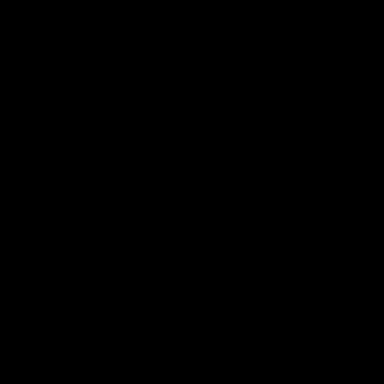

In [49]:

if __name__ == "__main__":
    image = Image.open(
        "/home/anhndt/draw_with_llms/data/results/version_4_sdxl_turbo_15--unknown_processing/1e9ac1-a lighthouse overlooking the ocean/raw - 0 - 0.5829.png"
    )
    svg, best_params,  best_size = image_to_svg(image)

    print(len(svg.encode('utf-8')))
    print(best_params)
    print(best_size)
    display(SVG(svg))

In [17]:
from IPython.display import SVG, display

with open("/home/anhndt/draw_with_llms/notebooks/export-2025-05-20 050210.svg", "r", encoding="utf-8") as f:
    svg_str = f.read()

print(len(svg_str.encode('utf-8')))
# display(SVG(svg_str))



9241


In [1]:
import io

import cairosvg
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter


class ImageProcessor:
    def __init__(self, image: Image.Image, seed=None):
        """Initialize with either a path to an image or a PIL Image object."""
        self.image = image
        self.original_image = self.image.copy()
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def reset(self):
        self.image = self.original_image.copy()
        return self

    def visualize_comparison(
        self,
        original_name="Original",
        processed_name="Processed",
        figsize=(10, 5),
        show=True,
    ):
        """Display original and processed images side by side."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        ax1.imshow(np.asarray(self.original_image))
        ax1.set_title(original_name)
        ax1.axis("off")

        ax2.imshow(np.asarray(self.image))
        ax2.set_title(processed_name)
        ax2.axis("off")

        title = f"{original_name} vs {processed_name}"
        fig.suptitle(title)
        fig.tight_layout()
        if show:
            plt.show()
        return fig

    def apply_median_filter(self, size=3):
        """Apply median filter to remove outlier pixel values.

        Args:
             size: Size of the median filter window.
        """
        self.image = self.image.filter(ImageFilter.MedianFilter(size=size))
        return self

    def apply_bilateral_filter(self, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to smooth while preserving edges.

        Args:
             d: Diameter of each pixel neighborhood
             sigma_color: Filter sigma in the color space
             sigma_space: Filter sigma in the coordinate space
        """
        # Convert PIL Image to numpy array for OpenCV
        img_array = np.asarray(self.image)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(img_array, d, sigma_color, sigma_space)

        # Convert back to PIL Image
        self.image = Image.fromarray(filtered)
        return self

    def apply_fft_low_pass(self, cutoff_frequency=0.5):
        """Apply low-pass filter in the frequency domain using FFT.

        Args:
             cutoff_frequency: Normalized cutoff frequency (0-1).
                  Lower values remove more high frequencies.
        """
        # Convert to numpy array, ensuring float32 for FFT
        img_array = np.array(self.image, dtype=np.float32)

        # Process each color channel separately
        result = np.zeros_like(img_array)
        for i in range(3):  # For RGB channels
            # Apply FFT
            f = np.fft.fft2(img_array[:, :, i])
            fshift = np.fft.fftshift(f)

            # Create a low-pass filter mask
            rows, cols = img_array[:, :, i].shape
            crow, ccol = rows // 2, cols // 2
            mask = np.zeros((rows, cols), np.float32)
            r = int(min(crow, ccol) * cutoff_frequency)
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
            mask[mask_area] = 1

            # Apply mask and inverse FFT
            fshift_filtered = fshift * mask
            f_ishift = np.fft.ifftshift(fshift_filtered)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.real(img_back)

            result[:, :, i] = img_back

        # Clip to 0-255 range and convert to uint8 after processing all channels
        result = np.clip(result, 0, 255).astype(np.uint8)

        # Convert back to PIL Image
        self.image = Image.fromarray(result)
        return self

    def apply_jpeg_compression(self, quality=85):
        """Apply JPEG compression.

        Args:
             quality: JPEG quality (0-95). Lower values increase compression.
        """
        buffer = io.BytesIO()
        self.image.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        self.image = Image.open(buffer)
        return self

    def apply_random_crop_resize(self, crop_percent=0.05):
        """Randomly crop and resize back to original dimensions.

        Args:
             crop_percent: Percentage of image to crop (0-0.4).
        """
        width, height = self.image.size
        crop_pixels_w = int(width * crop_percent)
        crop_pixels_h = int(height * crop_percent)

        left = self.rng.randint(0, crop_pixels_w + 1)
        top = self.rng.randint(0, crop_pixels_h + 1)
        right = width - self.rng.randint(0, crop_pixels_w + 1)
        bottom = height - self.rng.randint(0, crop_pixels_h + 1)

        self.image = self.image.crop((left, top, right, bottom))
        self.image = self.image.resize((width, height), Image.BILINEAR)
        return self

    def apply(self):
        """Apply an ensemble of defenses."""
        return (
            self.apply_random_crop_resize(crop_percent=0.03)
            .apply_jpeg_compression(quality=95)
            .apply_median_filter(size=9)
            .apply_fft_low_pass(cutoff_frequency=0.5)
            .apply_bilateral_filter(d=5, sigma_color=75, sigma_space=75)
            .apply_jpeg_compression(quality=92)
        )


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
         The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
         The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
         The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if "viewBox" not in svg_code:
        svg_code = svg_code.replace("<svg", f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode("utf-8"))
    return Image.open(io.BytesIO(png_data)).convert("RGB").resize(size)


In [2]:
import os

import clip
import torch
import torch.nn as nn
from PIL import Image


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)


class AestheticEvaluator:
    def __init__(self):
        self.model_path = "/home/anhndt/draw_with_llms/models/sac+logos+ava1-l14-linearMSE.pth"
        self.clip_model_path = "/home/anhndt/draw_with_llms/models/ViT-L-14.pt"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(
            self.model_path, weights_only=True, map_location=self.device
        )

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to(self.device)
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device=self.device)

        return predictor, clip_model, preprocessor

    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to(self.device).float())

        return score.item() / 10.0  # scale to [0, 1]

    def compute_clip_similarity(self, image: Image.Image, text: str) -> float:
        """
        Compute the similarity score between an image and a text using the CLIP model.

        Args:
            image (PIL.Image.Image): The input image to be compared.
            text (str): The text description to compare with the image.

        Returns:
            float: A similarity score between the image and text embeddings.
                Higher scores indicate greater similarity.
        """

        # Preprocess the image (resize, normalize, etc.), add batch dimension, and move to the correct device
        image = self.preprocessor(image).unsqueeze(0).to(self.device)

        # Tokenize the input text and move it to the correct device
        text = clip.tokenize([text]).to(self.device)

        # Disable gradient computation for inference
        with torch.no_grad():
            # Extract image features using CLIP
            image_features = self.clip_model.encode_image(image)
            # Extract text features using CLIP
            text_features = self.clip_model.encode_text(text)

        image_features /= image_features.norm(p=2, dim=-1, keepdim=True)
        text_features /= text_features.norm(p=2, dim=-1, keepdim=True)

        # Compute cosine similarity (dot product since CLIP features are normalized)
        similarity = max((image_features @ text_features.T).item(), 0)

        return similarity

aes_evaluator = AestheticEvaluator()

In [12]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compare_pil_images(img1: Image.Image, img2: Image.Image, size=(384, 384)):
    """
    So sánh hai ảnh PIL sau khi resize về kích thước cố định bằng SSIM và MSE.
    
    Parameters:
        img1 (PIL.Image.Image): Ảnh thứ nhất.
        img2 (PIL.Image.Image): Ảnh thứ hai.
        size (tuple): Kích thước resize (mặc định: 384x384).
    
    Returns:
        dict: {'ssim': ..., 'mse': ...}
    """
    # Resize và chuyển về grayscale
    img1_gray = img1.resize(size, Image.LANCZOS).convert('L')
    img2_gray = img2.resize(size, Image.LANCZOS).convert('L')

    # Chuyển sang mảng numpy
    arr1 = np.array(img1_gray)
    arr2 = np.array(img2_gray)

    # Tính SSIM
    score_ssim, _ = ssim(arr1, arr2, full=True)
    
    return float(score_ssim)


In [20]:
import re
import xml.etree.ElementTree as ET
from io import BytesIO
from itertools import product
import numpy as np
import cairosvg
import io

import vtracer
from PIL import Image
from scour import scour
from skimage.metrics import structural_similarity as ssim

default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""

def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
         The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
         The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
         The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if "viewBox" not in svg_code:
        svg_code = svg_code.replace("<svg", f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode("utf-8"))
    return Image.open(io.BytesIO(png_data)).convert("RGB").resize(size)

def compare_pil_images(img1: Image.Image, img2: Image.Image, size=(384, 384)):
    """
    So sánh hai ảnh PIL sau khi resize về kích thước cố định bằng SSIM và MSE.
    
    Parameters:
        img1 (PIL.Image.Image): Ảnh thứ nhất.
        img2 (PIL.Image.Image): Ảnh thứ hai.
        size (tuple): Kích thước resize (mặc định: 384x384).
    
    Returns:
        dict: {'ssim': ..., 'mse': ...}
    """
    # Resize và chuyển về grayscale
    img1_gray = img1.resize(size, Image.Resampling.LANCZOS).convert('L')
    img2_gray = img2.resize(size, Image.Resampling.LANCZOS).convert('L')

    # Chuyển sang mảng numpy
    arr1 = np.array(img1_gray)
    arr2 = np.array(img2_gray)

    # Tính SSIM
    score_ssim, _ = ssim(arr1, arr2, full=True)
    score_ssim = float(score_ssim)

    return score_ssim

def remove_version_attribute(svg_str: str) -> str:
    ET.register_namespace("", "http://www.w3.org/2000/svg")
    tree = ET.ElementTree(ET.fromstring(svg_str))
    root = tree.getroot()

    if "version" in root.attrib:
        del root.attrib["version"]

    output = BytesIO()
    tree.write(output, encoding="utf-8", xml_declaration=True)
    return output.getvalue().decode("utf-8")


def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    Adds nested circles with second darkest and second brightest colors from the existing SVG,
    positioned in one of the four corners (randomly selected) but positioned to avoid being
    cropped out during image processing.

    Parameters:
    -----------
    svg_code : str
        The original SVG string

    Returns:
    --------
    str
        Modified SVG with the nested circles added
    """
    import random
    from colorsys import rgb_to_hls

    # Check if SVG has a closing tag
    if "</svg>" not in svg_code:
        return svg_code

    # Extract viewBox if it exists to understand the dimensions
    viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
    if viewbox_match:
        viewbox = viewbox_match.group(1).split()
        try:
            x, y, width, height = map(float, viewbox)
        except ValueError:
            # Default dimensions if we can't parse viewBox
            width, height = 384, 384
    else:
        # Default dimensions if viewBox not found
        width, height = 384, 384

    # Function to convert hex color to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip("#")
        if len(hex_color) == 3:
            hex_color = "".join([c * 2 for c in hex_color])
        return tuple(int(hex_color[i: i + 2], 16) / 255 for i in (0, 2, 4))

    # Function to convert RGB to hex
    def rgb_to_hex(rgb):
        return "#{:02x}{:02x}{:02x}".format(
            int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)
        )

    # Function to calculate color lightness
    def get_lightness(color):
        # Handle different color formats
        if color.startswith("#"):
            rgb = hex_to_rgb(color)
            return rgb_to_hls(*rgb)[1]  # Lightness is the second value in HLS
        elif color.startswith("rgb"):
            rgb_match = re.search(r"rgb\((\d+),\s*(\d+),\s*(\d+)\)", color)
            if rgb_match:
                r, g, b = map(lambda x: int(x) / 255, rgb_match.groups())
                return rgb_to_hls(r, g, b)[1]
        return 0.5  # Default lightness if we can't parse

    # Extract all colors from the SVG
    color_matches = re.findall(
        r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code
    )

    # Default colors in case we don't find enough
    second_darkest_color = "#333333"  # Default to dark gray
    second_brightest_color = "#CCCCCC"  # Default to light gray

    if color_matches:
        # Remove duplicates and get unique colors
        unique_colors = list(set(color_matches))

        # Calculate lightness for each unique color
        colors_with_lightness = [
            (color, get_lightness(color)) for color in unique_colors
        ]

        # Sort by lightness (brightness)
        sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])

        # Handle different scenarios based on number of unique colors
        if len(sorted_colors) >= 4:
            # We have at least 4 unique colors - use 2nd darkest and 2nd brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[-2][0]
        elif len(sorted_colors) == 3:
            # We have 3 unique colors - use 2nd darkest and brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[2][0]
        elif len(sorted_colors) == 2:
            # We have only 2 unique colors - use the darkest and brightest
            second_darkest_color = sorted_colors[0][0]
            second_brightest_color = sorted_colors[1][0]
        elif len(sorted_colors) == 1:
            # Only one color - use it for second_darkest and a derived lighter version
            base_color = sorted_colors[0][0]
            base_lightness = sorted_colors[0][1]
            second_darkest_color = base_color

            # Create a lighter color variant if the base is dark, or darker if base is light
            if base_lightness < 0.5:
                # Base is dark, create lighter variant
                second_brightest_color = "#CCCCCC"
            else:
                # Base is light, create darker variant
                second_darkest_color = "#333333"

    # Ensure the colors are different
    if second_darkest_color == second_brightest_color:
        # If they ended up the same, modify one of them
        if get_lightness(second_darkest_color) < 0.5:
            # It's a dark color, make the bright one lighter
            second_brightest_color = "#CCCCCC"
        else:
            # It's a light color, make the dark one darker
            second_darkest_color = "#333333"

    # Base size for the outer circle
    base_outer_radius = width * 0.023

    # Randomize size by ±10%
    size_variation = base_outer_radius * 0.1
    outer_radius = base_outer_radius + \
        random.uniform(-size_variation, size_variation)

    # Define radii for inner circles based on outer radius
    middle_radius = outer_radius * 0.80
    inner_radius = middle_radius * 0.65

    # Calculate the maximum crop margin based on the image processing (5% of dimensions)
    # Add 20% extra margin for safety
    crop_margin_w = int(width * 0.05 * 1.2)
    crop_margin_h = int(height * 0.05 * 1.2)

    # Calculate center point based on the outer radius to ensure the entire circle stays visible
    safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)

    # Choose a random corner (0: top-left, 1: top-right, 2: bottom-left, 3: bottom-right)
    corner = random.randint(0, 3)

    # Position the circle in the chosen corner, accounting for crop margin
    if corner == 0:  # Top-left
        center_x = safe_offset
        center_y = safe_offset
    elif corner == 1:  # Top-right
        center_x = width - safe_offset
        center_y = safe_offset
    elif corner == 2:  # Bottom-left
        center_x = safe_offset
        center_y = height - safe_offset
    else:  # Bottom-right
        center_x = width - safe_offset
        center_y = height - safe_offset

    # Add a small random offset (±10% of safe_offset) to make positioning less predictable
    random_offset = safe_offset * 0.1
    center_x += random.uniform(-random_offset, random_offset)
    center_y += random.uniform(-random_offset, random_offset)

    # Round to 1 decimal place to keep file size down
    outer_radius = round(outer_radius, 1)
    middle_radius = round(middle_radius, 1)
    inner_radius = round(inner_radius, 1)
    center_x = round(center_x, 1)
    center_y = round(center_y, 1)

    # Create the nested circles
    outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
    middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
    inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'

    # Create a group element that contains all three circles
    group_element = f"<g>{outer_circle}{middle_circle}{inner_circle}</g>"

    # Insert the group element just before the closing SVG tag
    modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")

    # Calculate and add a comment with the byte size information
    outer_bytes = len(outer_circle.encode("utf-8"))
    middle_bytes = len(middle_circle.encode("utf-8"))
    inner_bytes = len(inner_circle.encode("utf-8"))
    total_bytes = outer_bytes + middle_bytes + inner_bytes

    corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
    byte_info = (
        f"<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, "
        f"inner={inner_bytes}, total={total_bytes}, "
        f"colors: dark={second_darkest_color}, light={second_brightest_color}, "
        f"position: {corner_names[corner]} -->"
    )

    # modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")

    return modified_svg


def image_to_svg(image: Image, max_size: int = 10000) -> str:
    image_rgb = image.convert("RGBA")
    resized_img = image_rgb.resize((384, 384), Image.Resampling.LANCZOS)
    pixels = list(resized_img.getdata())

    speckle_values = [10, 40, 60]
    layer_diff_values = [64, 124]
    color_precision_values = [4, 6, 8]
    # speckle_values = [10, 40, 60]
    # layer_diff_values = [64, 124]
    # color_precision_values = [4, 6, 8]

    best_svg = None
    best_params = {}
    best_similarity = 0.0
    best_size = 0  # theo dõi kích thước tốt nhất nhỏ hơn max_size

    for filter_speckle, layer_difference, color_precision in product(speckle_values, layer_diff_values, color_precision_values):
        svg_str = vtracer.convert_pixels_to_svg(
            rgba_pixels=pixels,
            size=resized_img.size,
            colormode="color",        # ["color"] or "binary"
            hierarchical="stacked",     # ["stacked"] or "cutout"
            mode="polygon",             # ["spline"], "polygon", "none"
            filter_speckle=filter_speckle,   # default: 4
            color_precision=color_precision,  # default: 6
            layer_difference=layer_difference,  # default: 16
            corner_threshold=60,  # default: 60
            length_threshold=4.0,  # in [3.5, 10] default: 4.0
            max_iterations=10,   # default: 10
            splice_threshold=45,  # default: 45
            path_precision=8,   # default: 8
        )

        options = scour.sanitizeOptions({
            'enable_comment_stripping': True,
            'remove_metadata': True,
            'remove_descriptions': True,
            'set_precision': 1,
            'remove_descriptive_elements': True,
            'strip_xml_prolog': True
        })

        add_o = add_ocr_decoy_svg(svg_str)
        optimized_svg = scour.scourString(add_o, options)
        byte_len = len(optimized_svg.encode("utf-8"))
        
        ssim = compare_pil_images(image, svg_to_png(svg_str))
        
        if byte_len <= max_size and byte_len > best_size:
            if best_similarity <= ssim:
                best_similarity = ssim
                display(SVG(optimized_svg))
                best_svg = remove_version_attribute(optimized_svg)
                best_svg = re.sub(r"<\?xml[^>]+\?>\s*", "", best_svg)
                best_params = {
                    "filter_speckle": filter_speckle,
                    "layer_difference": layer_difference,
                    "color_precision": color_precision,
                    "ssim": ssim
                }
                best_size = byte_len
    print(f"{best_params}")

    if best_svg:
        return best_svg
    else:
        return default_svg

In [5]:
input = "/home/anhndt/draw_with_llms/data/results/version_7_sdxl_turbo_01--unknown_processing/1e9ac1-a lighthouse overlooking the ocean/raw - 3 - 0.6030.png"

In [6]:
from IPython.display import SVG, display

In [7]:
import random
import numpy as np
import torch
seed = 42
print(f"--- Set up Random Seeds: {seed} ---")
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


--- Set up Random Seeds: 42 ---


In [8]:

import PIL.Image
import torch
from diffusers import AutoPipelineForText2Image


class StableDiffusionXL_Turbo:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_path = "stabilityai/sdxl-turbo"
        self.pipe = AutoPipelineForText2Image.from_pretrained(
            self.model_path,
            torch_dtype=torch.float16,
            variant="fp16",
        ).to(self.device)

    def generate(
        self,
        prompt: str,
        height: int = 512,
        width: int = 512,
        negative_prompt: str = "",
        num_inference_steps: int = 1,
        guidance_scale: float = 0.0,
        seed: int = 42,
    ) -> PIL.Image.Image:
        """Generates an image based on the given prompt using Stable Diffusion v2.

        Parameters
        ----------
        prompt : str
             The text prompt to generate an image from.
        height : int, optional
             Height of the generated image in pixels (default is 512).
        width : int, optional
             Width of the generated image in pixels (default is 512).
        negative_prompt : str, optional
             The text prompt to avoid in the generated image.
        num_inference_steps : int, optional
             The number of denoising steps (default is 20).
        guidance_scale : float, optional
             The scale for classifier-free guidance (default is 10).
        seed : int, optional
             The seed for random generation to ensure reproducibility (default is None, which results in random generation).

        Returns
        -------
        PIL.Image.Image
             The generated image.
        """
        generator = torch.Generator("cuda").manual_seed(seed)

        image = self.pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            width=width,
            height=height,
            generator=generator,
        ).images[0]

        return image


/home/anhndt/.conda/envs/draw-with-llms/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model = StableDiffusionXL_Turbo()

Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


In [18]:
prompt = "flat color illustration, a lighthouse overlooking the ocean, inspired by Tom Whalen, vibrant palette, bold outlines, simple shapes, app icon."

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


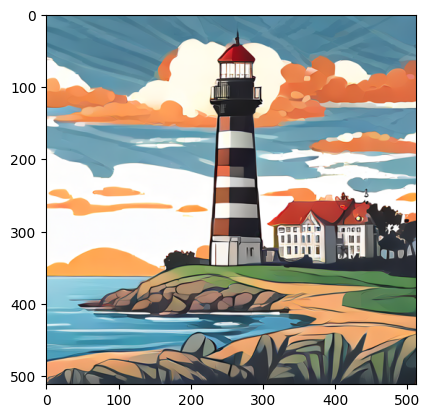

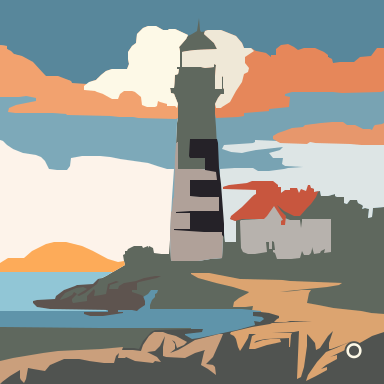

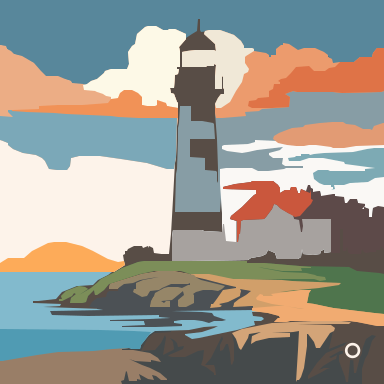

{'filter_speckle': 40, 'layer_difference': 64, 'color_precision': 6, 'ssim': 0.5879396845997086}


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


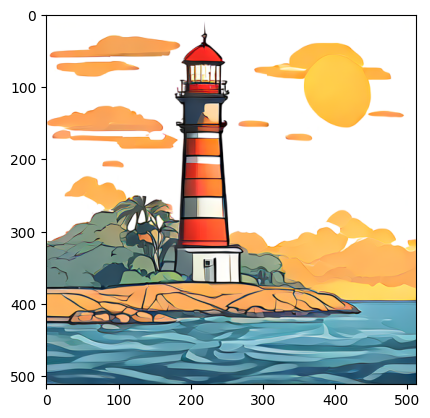

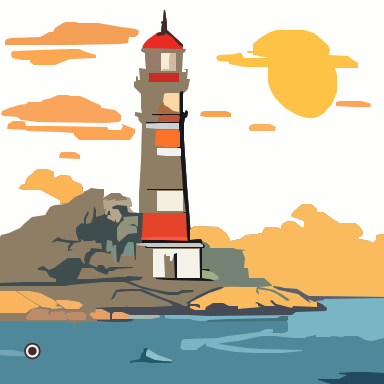

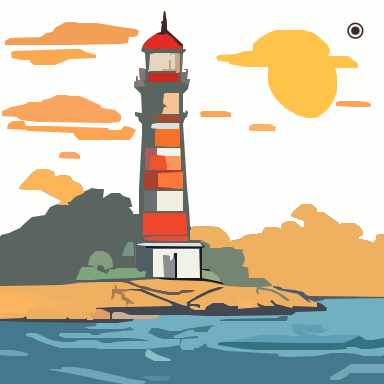

{'filter_speckle': 10, 'layer_difference': 124, 'color_precision': 8, 'ssim': 0.7460710626043314}


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


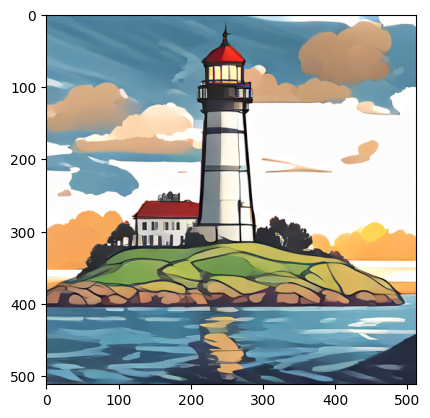

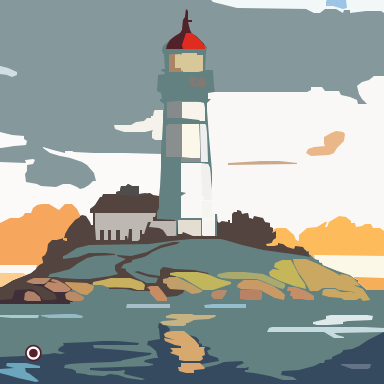

{'filter_speckle': 10, 'layer_difference': 124, 'color_precision': 4, 'ssim': 0.703852615374901}


100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


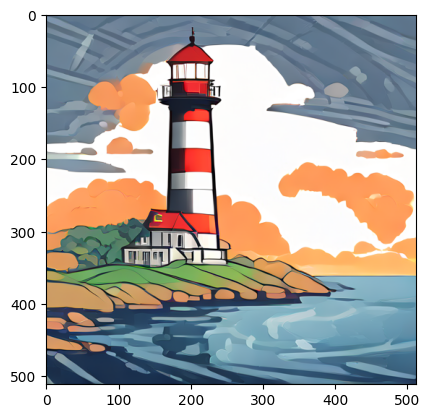

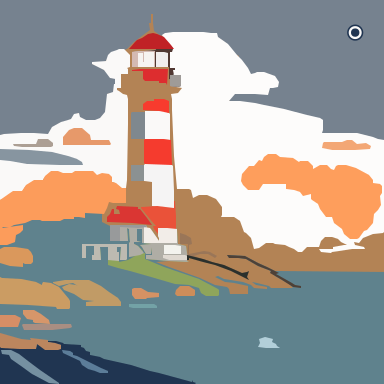

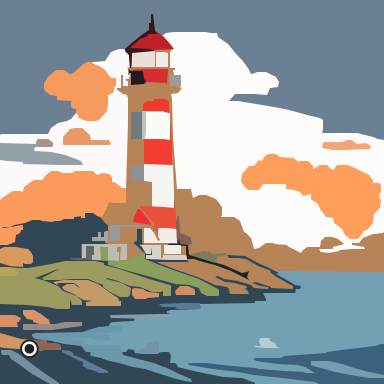

{'filter_speckle': 10, 'layer_difference': 124, 'color_precision': 6, 'ssim': 0.6959689402600588}


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


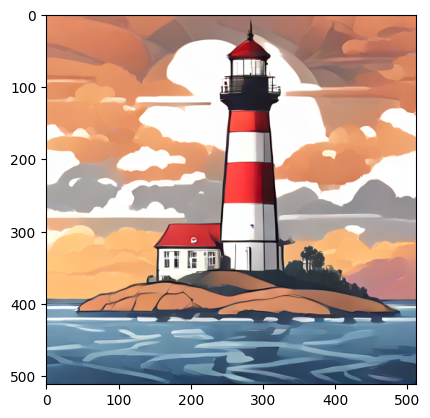

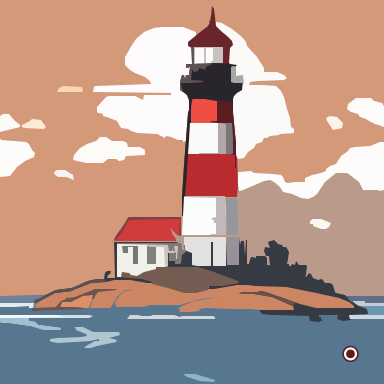

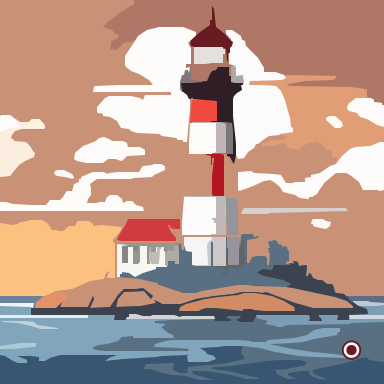

{'filter_speckle': 10, 'layer_difference': 124, 'color_precision': 8, 'ssim': 0.7438363456715524}


In [21]:
for i in range(5):
    image = model.generate(prompt=prompt, seed=42+i)
    plt.imshow(image)
    plt.show()
    svg = image_to_svg(image, max_size=10000)